# Random Phase Gadgets

Code for producing the family of circuits seen in **Figure 4** from _A quantum-classical cloud platform optimized for variational hybrid algorithms_.

In [1]:
import random
from typing import Optional

from pyquil import Program
from pyquil.gates import CNOT, H, MEASURE, RZ
from pyquil.latex import display

In [2]:
def random_phase_gadget(qubits: int, depth: int, seed: Optional[int] = None) -> Program:
    if seed:
        random.seed(seed)

    pairs = qubits // 2
    alphas =  pairs * depth
    permutation = list(range(qubits))
    random.shuffle(permutation)
    
    i = 0
    p = Program()
    alpha = p.declare("alpha", "REAL", alphas)
    for layer in range(depth):
        for pair in range(pairs):
            control = permutation[2 * pair]
            target = permutation[2 * pair + 1]
            p += H(control)
            p += H(target)
            p += CNOT(control, target)
            p += RZ(alpha[i], target)
            p += CNOT(control, target)
            i += 1
        random.shuffle(permutation)
    
    for qubit in permutation:
        p += H(qubit)

    ro = p.declare("ro", "BIT", qubits)
    for idx, qubit in enumerate(permutation):
        p += MEASURE(qubit, ro[idx])

    return p

In [3]:
m = d = 2
rpg = random_phase_gadget(m, d)
print(rpg)

DECLARE alpha REAL[2]
H 1
H 0
CNOT 1 0
RZ(alpha[0]) 0
CNOT 1 0
H 1
H 0
CNOT 1 0
RZ(alpha[1]) 0
CNOT 1 0
H 1
H 0
DECLARE ro BIT[2]
MEASURE 1 ro[0]
MEASURE 0 ro[1]



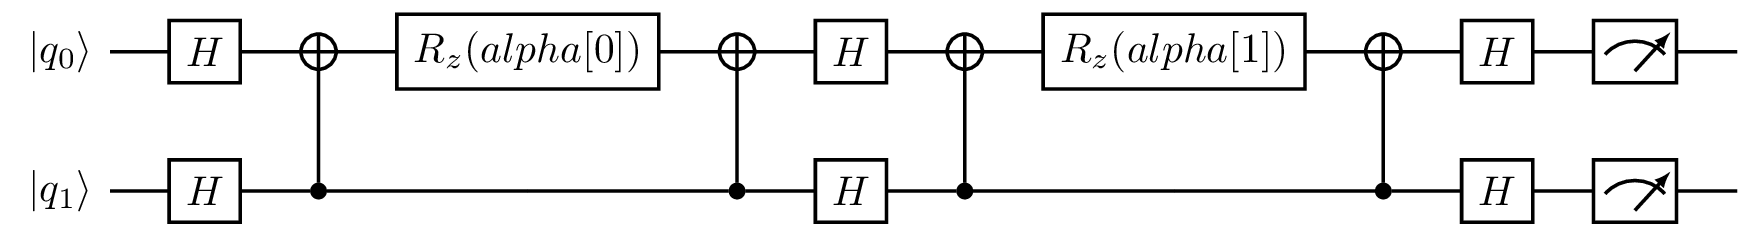

In [4]:
display(rpg)